## Example: Tuning a single-electron pump

In this notebook we want to show how our algorithm can be used on a double-dot to discover the tranisitions necessary to pump single electrons from source to drain.

We first start by setting up the simulation, then we learn gamma and then for each of the three states (0,0), (1,0), (0,1) we learn the polytopes and construct the necessary transitions.

In [1]:
#import our simulation
from simulator import sim_NxM, Simulator

#for the algorithm
import numpy as np
from fit_zero_boundary import learn_zero_polytope
from fit_convex_polytope import learn_convex_polytope, generate_transitions_for_state, sample_boundary_points

#for plotting
from scipy.spatial import HalfspaceIntersection, ConvexHull
from scipy.optimize import linprog
import matplotlib.pyplot as plt
%matplotlib inline

#some helper code:

#function that finds a point inside a given polytope
def find_feasible_point(halfspaces):
    norm_vector = np.reshape(np.linalg.norm(halfspaces[:, :-1], axis=1), (halfspaces.shape[0], 1))
    c = np.zeros((halfspaces.shape[1],))
    c[-1] = -1
    A = np.hstack((halfspaces[:, :-1], norm_vector))
    b = - halfspaces[:, -1:]
    res = linprog(c, A_ub=A, b_ub=b, bounds = (None,None))
    return res.x[:-1]

#plot a polytope on an axis object
#returns a point inside the polyope
def plot_2D_polytope(ax,A,b,color,lower_bounds, label=None):
    eqs= eqs=np.hstack([A,b.reshape(-1,1)])
    lower_bounds = np.hstack([-np.eye(2),lower_bounds.reshape(-1,1)])
    #add constraints to polytope
    eqs = np.vstack([eqs,lower_bounds])
    
    # Get the corners
    feasible_point = find_feasible_point(eqs)
    corners = HalfspaceIntersection(eqs, feasible_point).intersections

    #Easiest way to get proper line-segments of the boundaries in 2D is via the convex hull
    # Form a convex hull based on the corners
    hull = ConvexHull(corners)
    # Plot lines between the points forming the hull (they are assumed to come in counterclockwise order)
    for i,simplex in enumerate(hull.simplices):
        label_trace = label
        if i != 0:
            label_trace = None
        ax.plot(corners[simplex, 0], corners[simplex, 1], '-', c=color, lw=3,label=label_trace)
    return feasible_point

#function that computes a Charge Stability Diagram from a simulation of a device with two dots
# sim: our simulator
# ax: axis object to plot into
# max_occupation: the maximum number of electrons per dot
# minV: minimum voltage to raster
# maxV: maximum voltage to raster
def raster_CFD(sim, ax, max_occupation = 4, minV=-0.1, maxV=0.4, resolution=100):
    CSD=np.zeros((resolution,resolution))
    # Loop over all combinations of the two dots
    for n1 in range(0,max_occupation):
        for n2 in range(0,max_occupation):
            # Set the device in the corresponding charge state
            sim.activate_state([n1,n2])

            #compute the polytope (the simulation caches this!)
            polytope=sim.boundaries()
            A=polytope.A #normals of boundaries
            b=polytope.b #offsets of boundaries

            #plot the polytope
            
            # All polytopes with 0 electron occupation on a dot are unbounded from below
            # Thus, we need to add lower-bound constraints for computing the boundaries of unbounded polytopes.
            lower_bounds = 1.05*minV*np.ones((2))
            point_inside = plot_2D_polytope(ax,A,b,'white',lower_bounds)

            # Add charge state text 
            if( point_inside[0] < 0.4 and point_inside[1] < 0.4 ):
                #take special considerations for the lower bounds, as our constraint for the lower bound
                #in the device might be a lot larger than minV
                x_pos = point_inside[0]-0.025
                if (x_pos < minV):
                    x_pos = minV + 0.025
                y_pos = point_inside[1]-0.025
                if (y_pos < minV):
                    y_pos = minV + 0.025
                        
                ax.text(x_pos, y_pos, "(%d,%d)"%(n1,n2), c="white")

            # Raster scan all voltages and see if we're inside the polytope
            for i,v1 in enumerate(np.linspace(minV,maxV,resolution)):
                for j,v2 in enumerate(np.linspace(minV,maxV,resolution)):
                    CSD[i,j] = (1+n1+n2) if sim.inside_state([v1,v2]) else CSD[i,j]
            ax.imshow(CSD.T, origin='lower', extent=[-0.1,0.4,-0.1,0.4])

## Step 1: initializing the simulation

First, we create the simulation. We simulate a 1x2 array according to the constant interaction model. 

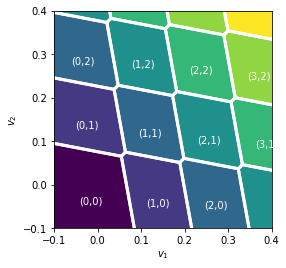

In [2]:
# Set a seed for reproducability
np.random.seed(0)

delta = 1.0/1000
rho=0.1
sim = sim_NxM(1, 2, delta, rho)
sim.set_reservoir(True)
#a first plot of the CSD
fig, ax = plt.subplots()
raster_CFD(sim, ax, max_occupation = 4, minV=-0.1, maxV=0.4, resolution=100)
ax.set_xlabel("$v_1$")
ax.set_ylabel("$v_2$")
ax.set_xticks([-0.1,0, 0.1, 0.2, 0.3, 0.4])
ax.set_yticks([-0.1,0, 0.1, 0.2, 0.3, 0.4])
pass

## Computing Gamma

To compute gamma, we first learn the boundaries of the state (0,0). We then label the learned transitions based on which we think adds one electron to the i-th dot.

For a quick verification that the learned boundaries are correct, we overlay the learned boundaries on top of the rastered charge stability diagram and compute the relative error of each element. 

relative error in %
[[1.07434180e-03 3.28054498e-02]
 [1.85760928e-03 6.76606568e-05]]


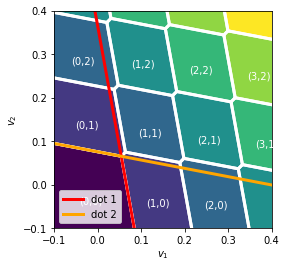

In [3]:
#set the simulation to the polytope of the 0,0 state
sim.activate_state([0,0])

#learning the polytope belonging to the 0,0 state has its own algorithm
num_start_samples = 4*sim.num_dots*(sim.num_dots+5) #number of initial line-searches (same as in the paper)
halfspaces, _,_,_ = learn_zero_polytope(sim, delta, num_start_samples = num_start_samples)

# A priori, we do not know which transition (row of gamma) belongs to which dot
# We're assuming that each dot has one sensor (dot), so we order the rows s.t. for dot i gamma_ii is the largest element
gamma_order = []
for i in range(sim.num_dots):
    jmax = -1
    maxv = -np.infty
    for j in range(sim.num_dots):
        if j in gamma_order: continue
        if np.abs(halfspaces[j,i]) > maxv:
            maxv = np.abs(halfspaces[j,i])
            jmax = j
    gamma_order.append(jmax)
halfspaces=halfspaces[gamma_order,:]


halfspaces /= np.linalg.norm(halfspaces[:,:-1],axis=1).reshape(-1,1) #normalize to unit length normals
gamma = halfspaces[:,:-1]#normal
b = halfspaces[:,-1]#offset

print("relative error in %")
gamma_truth = sim.boundaries().A/np.linalg.norm(sim.boundaries().A,axis=1).reshape(-1,1)
print(100*np.abs(gamma_truth-gamma)/gamma)

#plotting the learned state
fig, ax = plt.subplots()
raster_CFD(sim, ax, max_occupation = 4, minV=-0.1, maxV=0.4, resolution=100)
ax.set_xlabel("$v_1$")
ax.set_ylabel("$v_2$")
ax.set_xticks([-0.1,0, 0.1, 0.2, 0.3, 0.4])
ax.set_yticks([-0.1,0, 0.1, 0.2, 0.3, 0.4])
ax.set_xlim(-0.1,0.4)
ax.set_ylim(-0.1,0.4)
#plot the boundaries
xs=np.linspace(-0.1,0.4,100)
colors=["red", "orange"]
for i in range(2):
    ys= (-b[i] - gamma[i,0]*xs)/gamma[i,1]
    ax.plot(xs,ys,color=colors[i],label="dot "+str(i+1),linewidth=3)
plt.legend()
pass

### Now learn all of the other polytopes that are relevant to the target states

In [4]:
# Set a seed for reproducability
np.random.seed(0)

#the states we want to compute polytopes for
target_states=np.array([[0,1],[1,0]],dtype=np.int64)

# Generate from these states all of the transitions we want to look for
Ts = [generate_transitions_for_state(s, max_k=2, max_moves = 1) for s in target_states]

# here we store the learned polytopes
polytopes=[]

for state_idx,target_state in enumerate(target_states):
        
    # Set device in the target state
    print("\nComputing polytope for state ", target_state)
    sim.activate_state(target_state)
    
    #the set of transitions we search for
    T=Ts[state_idx]
    print("searching for transitions")
    print(T)

    # we need a starting point to create a polytope
    #this is slightly cheating, since we compute a point from the ground turth polytope
    startpoint = sim.boundaries().point_inside
    #this is less cheating and how we do it in the paper.
    #startpoint, _, _ = sim.line_search(sim.boundaries().point_inside, np.random.randn(sim.num_inputs))
    #startpoint = 0.95*startpoint + 0.05 * sim.boundaries().point_inside
    print("start point:", startpoint)
    # Learn the polytope (set verbose = 2 for more output, such as the convergence of the max likelihood)
    A, b, x_m, x_p, found, num_searches = learn_convex_polytope(sim, delta, startpoint, T.astype(float), gamma, max_searches=200, verbose=1)
    
    #store only the equations of transitions we have found
    polytopes.append({"A":A[found], "b":b[found], "labels":T[found]})


Computing polytope for state  [0 1]
searching for transitions
[[ 0 -1]
 [ 0  1]
 [ 1  0]
 [ 1 -1]]
start point: [-0.91425287  0.32511988]
Number of searches:  16 / 200
Number of searches:  28 / 200
Number of searches:  40 / 200
Finished learning polytope
Number of transitions found: 4
max_rad not found: 0.0
[ 0. -1.] 11 1.0362878987005535
[0. 1.] 11 1.0278767832954034
[1. 0.] 13 0.07339399738519467
[ 1. -1.] 7 0.0066602799516956275

Computing polytope for state  [1 0]
searching for transitions
[[-1  0]
 [ 0  1]
 [ 1  0]
 [-1  1]]
start point: [ 0.29673864 -0.91110172]
Number of searches:  16 / 200
Number of searches:  26 / 200
Number of searches:  38 / 200
Number of searches:  47 / 200
Number of searches:  56 / 200
Number of searches:  62 / 200
Number of searches:  68 / 200
Finished learning polytope
Number of transitions found: 4
max_rad not found: 0.0
[-1.  0.] 16 1.0410911916811438
[0. 1.] 18 0.06370426993465476
[1. 0.] 16 1.0335824645786085
[-1.  1.] 8 0.006517565350695392


## Plot

We plot the learned polytopes as well as points computed to lie on a given transition. Using these points, it is possible to change electron configurations by picking a line from within one state through these points.

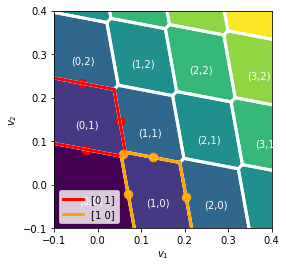

In [5]:


#overlay the learned polytopes on top of the CSD
fig, ax = plt.subplots()
raster_CFD(sim, ax, max_occupation = 4, minV=-0.1, maxV=0.4, resolution=100)
ax.set_xlabel("$v_1$")
ax.set_ylabel("$v_2$")
ax.set_xticks([-0.1,0, 0.1, 0.2, 0.3, 0.4])
ax.set_yticks([-0.1,0, 0.1, 0.2, 0.3, 0.4])
ax.set_xlim(-0.1,0.4)
ax.set_ylim(-0.1,0.4)

lower_bounds = -0.11*np.ones((2))
#plot the boundaries of the polytopes
plot_2D_polytope(ax,polytopes[0]["A"],polytopes[0]["b"],"red",lower_bounds, label=str(target_states[0]))
plot_2D_polytope(ax,polytopes[1]["A"],polytopes[1]["b"],"orange",lower_bounds, label=str(target_states[1]))

#for each polytope constrnp.arrayuct a point on each boundary
_, _, means = sample_boundary_points(polytopes[0]["A"], polytopes[0]["b"], -np.eye(2), lower_bounds)
means = np.array(means)
plt.scatter(means[:,0],means[:,1], color="red",s=72)
_, _, means = sample_boundary_points(polytopes[1]["A"], polytopes[1]["b"], -np.eye(2), lower_bounds)
means = np.array(means)
plt.scatter(means[:,0],means[:,1], color="orange",s=72)
plt.legend()
pass